In [1]:
import torch
import gc
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig
from datasets import load_dataset
import evaluate
from peft import LoraConfig, TaskType, get_peft_model, AutoPeftModelForCausalLM , PeftModel
import wandb

In [ ]:
config = {
  "run_name" : 'final_config' , 
  "train_batch_size": 4,
  "eval_batch_size": 4,
  "learning_rate": 2e-4,
  "num_train_epochs": 3,
  "logging_steps": 250,
  "eval_steps": 500,
  "save_steps": 500,
  "lora_r": 16,
  "lora_alpha": 32 ,
  "lora_dropout": 0.05,
  "target_modules": ["c_attn", "c_proj", "c_fc", "mlp.c_proj"]
}

# Model and tokenizer setup
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
# Set pad token to eos_token for causal LM
tokenizer.pad_token = tokenizer.eos_token

model_config = AutoConfig.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, config=model_config)
model.resize_token_embeddings(len(tokenizer))  # ensure embeddings cover pad token

dataset = load_dataset("squad")
# Take a small validation subset for quick checks
vali_ds = dataset["validation"].shuffle(seed=42).select(range(400))
# Split train into train/test for fine-tuning and eval
split = dataset["train"].train_test_split(test_size=0.1, seed=42)
train_ds = split["train"].shuffle(seed=42).select(range(6000))
eval_ds  = split["test"].shuffle(seed=42).select(range(300))

del dataset, split
gc.collect()



In [3]:

# Preprocessing function for causal LM QA
max_length = 2048

def preprocess_function(examples):
    inputs = []
    targets = []
    for context, question, answers in zip(examples['context'], examples['question'], examples['answers']):
        # extract first answer text
        answer_text = answers['text'][0]
        # build prompt and full text
        target = " "+ answer_text + tokenizer.eos_token
        full_text = f"Context: {context}\nQuestion: {question}\nAnswer:"+ target 
        targets.append(target.replace(u'\xa0', u' '))


        inputs.append(full_text.replace(u'\xa0', u' '))
        
    # tokenize full sequences
    model_inputs = tokenizer(
        inputs,
        max_length=max_length,
        truncation=True,
        padding=False,
        add_special_tokens=True 
    )
    targets_len = [len(t_ids) for t_ids in tokenizer(targets, add_special_tokens=False).input_ids ]
    labels = []
    for i, input_ids in enumerate(model_inputs['input_ids']):
        label_ids = [-100]* (len(input_ids)-targets_len[i])  + input_ids[-targets_len[i]:]
        labels.append(label_ids)
    model_inputs['labels'] = labels
    return model_inputs

# Data collator
class QADataCollator:
    def __init__(self, tokenizer, max_length=256):
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __call__(self, features):
        batch_input_ids = [torch.tensor(f['input_ids']) for f in features]
        batch_attention = [torch.tensor(f['attention_mask']) for f in features]
        batch_labels     = [torch.tensor(f['labels']) for f in features]

        
        input_ids = torch.nn.utils.rnn.pad_sequence(
            batch_input_ids , batch_first=True, padding_value=self.tokenizer.pad_token_id
        )
        attention_mask = torch.nn.utils.rnn.pad_sequence(
            batch_attention, batch_first=True, padding_value=0
        )
        labels = torch.nn.utils.rnn.pad_sequence(
            batch_labels , batch_first=True, padding_value=-100
        )
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': labels,
        }



# Apply preprocessing
tok_train_ds = train_ds.map(
    preprocess_function,
    batched=True,
    remove_columns=train_ds.column_names,
)
tok_eval_ds = eval_ds.map(
    preprocess_function,
    batched=True,
    remove_columns=eval_ds.column_names,
)

print(f"Training examples: {len(tok_train_ds)}")
print(f"Eval examples: {len(tok_eval_ds)}")


Training examples: 6000
Eval examples: 300


## model Train

In [4]:




wandb.init(project="lora-squad", name = config['run_name'] ,  config=config)


# Freeze base model parameters
for param in model.parameters():
    param.requires_grad = False

# LoRA configuration
lora_config = LoraConfig(
    r= config['lora_r'] ,
    lora_alpha=config['lora_alpha'],
    lora_dropout= config['lora_dropout'],
    task_type=TaskType.CAUSAL_LM,
    target_modules= config['target_modules']
)
# Wrap model with LoRA
lora_model = get_peft_model(model, lora_config)
lora_model.print_trainable_parameters()


# Verify LoRA setup
#for name, param in lora_model.named_parameters():
#    if param.requires_grad:
#        print(f"Trainable: {name}")

# Data collator instance
data_collator = QADataCollator(tokenizer, max_length=max_length)





# Training setup
from transformers import TrainingArguments, Trainer
training_args = TrainingArguments(
    output_dir="./lora_squad",
    per_device_train_batch_size=config['train_batch_size'],
    per_device_eval_batch_size=config['eval_batch_size'],
    learning_rate= config['learning_rate'] ,
    num_train_epochs= config['num_train_epochs'],
    logging_steps=config['logging_steps'],
    eval_strategy="steps",
    eval_steps=config['eval_steps'],
    save_steps=config['save_steps'],
    save_total_limit=2,
    load_best_model_at_end=True,   
    report_to=["wandb"],
    run_name="lora-squad-run",  
)

trainer = Trainer(
    model=lora_model,
    args=training_args,
    train_dataset=tok_train_ds,
    eval_dataset=tok_eval_ds,
    data_collator=data_collator,
    #callbacks=[LoggingCallback(logger)]
)

# Train
print("Starting training...")
trainer.train()

# Evaluate
evaluation_result = trainer.evaluate()
print("Evaluation results:", evaluation_result)

# Save the fine-tuned model
lora_model.save_pretrained("./lora_squad")


wandb: You can find your API key in your browser here: http://localhost:8080/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

  ········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for localhost:8080 to your netrc file: C:\Users\Aha\_netrc
wandb: Currently logged in as: abcde to http://localhost:8080. Use `wandb login --relogin` to force relogin


C:\Users\Aha\AppData\Local\Programs\Python\Python312\Lib\site-packages\peft\tuners\lora\layer.py:1803: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


trainable params: 2,359,296 || all params: 126,799,104 || trainable%: 1.8607


No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Starting training...


C:\Users\Aha\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\integrations\sdpa_attention.py:66: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss,Validation Loss
500,1.016100,0.730582
1000,0.851000,0.659836
1500,0.815200,0.644660
2000,0.720200,0.646412
2500,0.667700,0.620169
3000,0.673100,0.601514
3500,0.542900,0.611377
4000,0.549500,0.615552
4500,0.537700,0.603587


C:\Users\Aha\AppData\Local\Programs\Python\Python312\Lib\site-packages\peft\utils\other.py:1221: UserWarning: Unable to fetch remote file due to the following error (ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: 184f0357-7b6b-45a5-aae9-e1e86055f281)') - silently ignoring the lookup for the file config.json in gpt2.
  warnings.warn(
C:\Users\Aha\AppData\Local\Programs\Python\Python312\Lib\site-packages\peft\utils\save_and_load.py:238: UserWarning: Could not find a config file in gpt2 - will assume that the vocabulary was not modified.
  warnings.warn(
C:\Users\Aha\AppData\Local\Programs\Python\Python312\Lib\site-packages\peft\utils\other.py:1221: UserWarning: Unable to fetch remote file due to the following error (ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: 98f70854-41fb-4664-80b8-8c21c4972bce)') - silently ignoring the lookup for the fi

Evaluation results: {'eval_loss': 0.6015138030052185, 'eval_runtime': 49.3907, 'eval_samples_per_second': 6.074, 'eval_steps_per_second': 1.519, 'epoch': 3.0}


C:\Users\Aha\AppData\Local\Programs\Python\Python312\Lib\site-packages\peft\utils\other.py:1221: UserWarning: Unable to fetch remote file due to the following error (ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: 6944cc1a-0eda-428a-b26a-6caff4f15308)') - silently ignoring the lookup for the file config.json in gpt2.
  warnings.warn(
C:\Users\Aha\AppData\Local\Programs\Python\Python312\Lib\site-packages\peft\utils\save_and_load.py:238: UserWarning: Could not find a config file in gpt2 - will assume that the vocabulary was not modified.
  warnings.warn(


## model evaulation

In [4]:

def generate_answer(model, tokenizer, context, question, max_new_tokens=50,do_sample=False,temperature=1.0,top_k=0,top_p=1.0):
    prompt = f"Context: {context}\nQuestion: {question}\nAnswer: "
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    gen_kwargs = {
        "max_new_tokens": max_new_tokens,
        "do_sample": do_sample,
        "pad_token_id": tokenizer.pad_token_id,
    }
    if do_sample:
        gen_kwargs["temperature"] = temperature
        if top_k is not None:
            gen_kwargs["top_k"] = top_k
        if top_p is not None:
            gen_kwargs["top_p"] = top_p
    
    output = model.generate(**inputs, **gen_kwargs)
    
    gen_tokens = output[0][inputs['input_ids'].shape[1]:]
    answer = tokenizer.decode(gen_tokens, skip_special_tokens=True)
    return answer

# Load fine-tuned model for testing
base_model = AutoModelForCausalLM.from_pretrained(model_name, config=config)
ft_model = PeftModel.from_pretrained(base_model, "./lora_squad")
#ft_model.disable_adapter() 
#ft_model = base_model
ft_model.eval()


PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): GPT2LMHeadModel(
      (transformer): GPT2Model(
        (wte): Embedding(50257, 768)
        (wpe): Embedding(1024, 768)
        (drop): Dropout(p=0.1, inplace=False)
        (h): ModuleList(
          (0-11): 12 x GPT2Block(
            (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (attn): GPT2Attention(
              (c_attn): lora.Linear(
                (base_layer): Conv1D(nf=2304, nx=768)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=768, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=2304, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
        

In [ ]:
WBinitiated = wandb.run is not None

# Test on validation examples
print("\n=== Testing Fine-tuned Model ===")
for i, example in enumerate(vali_ds):
    if i >= 3:
        break
    pred = generate_answer(ft_model, tokenizer, example['context'], example['question'])
    print(f"Example {i+1}:")
    print("Question:", example['question'])
    print("Prediction:", pred)
    print("Ground truth:", example['answers']['text'][0])
    print()

    if WBinitiated:
        wandb.log({
            "example_id": example['id'],
            "question": example['question'],
            "ground_truth": example['answers']['text'][0],
            "prediction": pred
        })

# Compute SQuAD metrics
predictions = []
references = []
for example in vali_ds:
    pred = generate_answer(ft_model, tokenizer, example['context'], example['question'])
    predictions.append({"id": example['id'], "prediction_text": pred})
    references.append({"id": example['id'], "answers": example['answers']})

squad_metric = evaluate.load("squad")
results = squad_metric.compute(predictions=predictions, references=references)
print(f"\nSQuAD Metrics: {results}")

if WBinitiated:
    wandb.log(results)
    # Finish wandb run
    wandb.finish()



=== Testing Fine-tuned Model ===
Example 1:
Question: In what year did Massachusetts first require children to be educated in schools?
Prediction:  1852
Ground truth: 1852

Example 2:
Question: When were stromules discovered?
Prediction:  1962
Ground truth: 1962

Example 3:
Question: Which artist who had a major influence on the Gothic Revival is represented in the V&A's British galleries?
Prediction:  Horace Walpole
Ground truth: Horace Walpole



In [5]:
decoding_configs = [
    {"name": "Greedy", "do_sample": False},
    {"name": "Top-k (k=10)", "do_sample": True, "top_k": 10},
    {"name": "Top-k (k=25)", "do_sample": True, "top_k": 25},
    {"name": "Top-k (k=50)", "do_sample": True, "top_k": 50},
    {"name": "Top-p (p=0.8)", "do_sample": True, "top_p": 0.8},
    {"name": "Top-p (p=0.9)", "do_sample": True, "top_p": 0.9},
    {"name": "Top-p (p=0.95)", "do_sample": True, "top_p": 0.95},
    {"name": "Temperature 0.7", "do_sample": True, "temperature": 0.7},
    {"name": "Temperature 1.0", "do_sample": True, "temperature": 1.0},
    {"name": "Temperature 1.3", "do_sample": True, "temperature": 1.3},
]

results = {}
for config in decoding_configs:
    print(f"\n=== Testing: {config['name']} ===")

    predictions = []
    references = []

    for example in vali_ds:
        pred = generate_answer(
            ft_model, tokenizer,
            example['context'], example['question'],
            max_new_tokens=50,
            do_sample=config["do_sample"],
            temperature=config.get("temperature", 1.0),
            top_k=config.get("top_k", 0),
            top_p=config.get("top_p", 1.0)
        )
        predictions.append({"id": example['id'], "prediction_text": pred})
        references.append({"id": example['id'], "answers": example['answers']})


    # Compute and log metrics for this config
    squad_metric = evaluate.load("squad")
    result = squad_metric.compute(predictions=predictions, references=references)
    results[config['name']] = result
    print(f"SQuAD Metrics ({config['name']}): {result}")
    


=== Testing: Greedy ===
SQuAD Metrics (Greedy): {'exact_match': 32.0, 'f1': 42.724612041009095}

=== Testing: Top-k (k=10) ===
SQuAD Metrics (Top-k (k=10)): {'exact_match': 23.25, 'f1': 33.24106903641948}

=== Testing: Top-k (k=25) ===
SQuAD Metrics (Top-k (k=25)): {'exact_match': 22.25, 'f1': 31.334445273191246}

=== Testing: Top-k (k=50) ===
SQuAD Metrics (Top-k (k=50)): {'exact_match': 19.5, 'f1': 30.461106519444623}

=== Testing: Top-p (p=0.8) ===
SQuAD Metrics (Top-p (p=0.8)): {'exact_match': 23.5, 'f1': 32.783404898478445}

=== Testing: Top-p (p=0.9) ===
SQuAD Metrics (Top-p (p=0.9)): {'exact_match': 22.5, 'f1': 33.13020609163799}

=== Testing: Top-p (p=0.95) ===
SQuAD Metrics (Top-p (p=0.95)): {'exact_match': 22.5, 'f1': 29.932241600991595}

=== Testing: Temperature 0.7 ===
SQuAD Metrics (Temperature 0.7): {'exact_match': 22.25, 'f1': 32.05306540649791}

=== Testing: Temperature 1.0 ===
SQuAD Metrics (Temperature 1.0): {'exact_match': 19.5, 'f1': 29.151710810689142}

=== Testin

In [9]:
import matplotlib.pyplot as plt

def plot_results(results, sort_by="f1", title=""):
    if sort_by not in ["f1", "exact_match"]:
        raise ValueError("sort_by must be either 'f1' or 'exact_match'")

    # Sort results by selected metric
    sorted_items = sorted(results.items(), key=lambda item: item[1][sort_by], reverse=True)
    config_names = [item[0] for item in sorted_items]
    em_scores = [item[1]['exact_match'] for item in sorted_items]
    f1_scores = [item[1]['f1'] for item in sorted_items]

    x = np.arange(len(config_names))
    width = 0.35

    fig, ax = plt.subplots(figsize=(13, 6))

    rects1 = ax.bar(x - width/2, em_scores, width, label='Exact Match', color='#4C72B0')
    rects2 = ax.bar(x + width/2, f1_scores, width, label='F1 Score', color='#55A868')

    ax.set_ylabel('Score (%)')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(config_names, rotation=30, ha='right')
    ax.set_ylim(0, 100)
    ax.legend()

    def add_labels(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.1f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', fontsize=9)

    add_labels(rects1)
    add_labels(rects2)

    fig.tight_layout()
    plt.show()


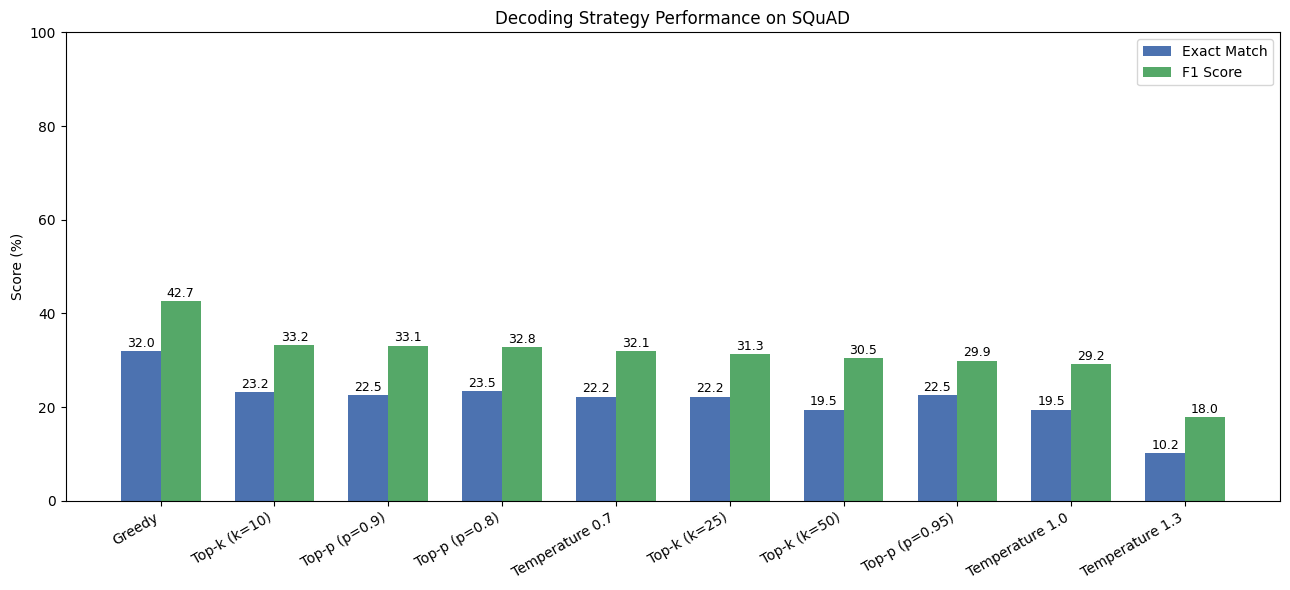

In [10]:
plot_results(results, sort_by="f1" , title = "Decoding Strategy Performance on SQuAD")